In [107]:
import uproot as uproot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from scipy.optimize import curve_fit
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

In [8]:
rc("pdf", fonttype=42)
rc("axes", labelsize=22)
rc("xtick", labelsize=22, top=True, direction="in")
rc("ytick", labelsize=22, right=True, direction="in")
rc("axes", titlesize=22)
rc("legend", fontsize=22, title_fontsize=22)
rc("font", size=22)
#set font as Georgia
#rc('text', usetex=True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Georgia"
})

def cm2inch(value):
    return value/2.54

1.4965793582966247
0.15242903052773266
[13.76191515 -0.37593527  0.05017999]


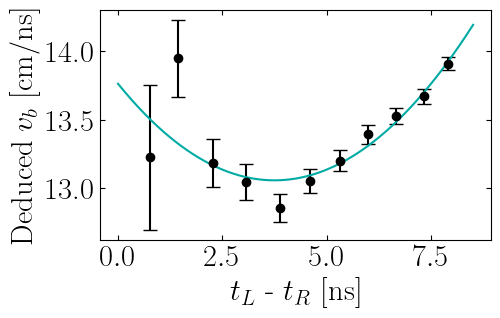

In [260]:
file = uproot.open("output/velocity.root")
solGraph = file["speedOfLightGraph"]
positions, speeds = solGraph.values()
errorsx, errorsy = solGraph.errors("high")

def solFun(x, *popt):
    a = popt[0]
    b = popt[1]
    c = popt[2]
    return a + b*x + c*x*x
    
popt, pcov = curve_fit(solFun, positions, speeds, p0=[0.5, 0.5, 0.5], sigma=errorsy, absolute_sigma=True)

#do chi^2 test
chi2 = np.sum(((solFun(positions, *popt) - speeds)/errorsy)**2)
ndf = len(positions) - len(popt)
print(chi2/ndf)
print(stats.chi2.sf(chi2, ndf))
print(popt)

x = np.linspace(0, 8.5, 1000)

fig, ax = plt.subplots(figsize=(cm2inch(12.8), cm2inch(7.6)))
ax.errorbar(positions, speeds, yerr=errorsy, fmt="o", color="black", capsize=5, label="Data")
ax.plot(x, solFun(x, *popt), color="#00ABA4", label="Fit")
ax.set_xlabel(r"$t_L$ - $t_R$  [ns]")
ax.set_ylabel(r"Deduced $v_b$ [cm/ns]")
ax.set_yticks((np.linspace(13, 14,3)))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=22, verticalalignment="top", bbox=props)
fig.savefig("../../indiePlakat/speedOfLight.svg", bbox_inches="tight", transparent=True)


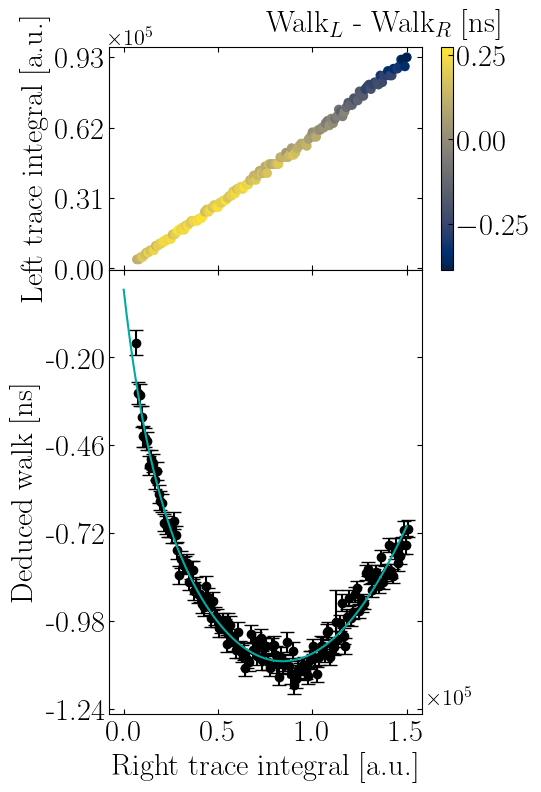

In [218]:
file = uproot.open("output/walkCorrecter.root")
walkTH2D = file["Walk plot"]
th2d = walkTH2D.to_numpy()
y_bins = th2d[2]/1e5
x_bins = th2d[1]/1e5
H = th2d[0]

x_vals = []
y_vals = []
heights = []

for i in range(len(x_bins[:-1])):
    for j in range(len(y_bins[:-1])):
        if H[j][i] == 0:
            #do nothing
            1
        else:
            x_vals.append(x_bins[i])
            y_vals.append(y_bins[j])
            heights.append(H[j][i])

par = [0.454605, 7.39858e-05, 1.53754e-05, -9.16516e-11]
def walk(qdc, *par):
    a = par[0]
    b = par[1]
    c = par[2]
    d = par[3]
    return a*(1-np.exp(-qdc*b)) + c*qdc + d*qdc*qdc

walkCorrVec = np.transpose(np.loadtxt("output/walkCorrecterVectors.txt"))
qdc_L = walkCorrVec[0]
qdc_R = walkCorrVec[1]
t_diff = walkCorrVec[2]
t_diff_err = walkCorrVec[3]

qdcspace = np.linspace(0,150e3,1000)

#plot th2d as a numpy histogram
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize=(cm2inch(12.8), cm2inch(22)),sharex=True,gridspec_kw={'height_ratios': [1, 2]})
im1 = ax[0].scatter(x_vals, y_vals, c=heights, cmap="cividis")
#make colorbar
cbar = fig.colorbar(im1, ax=ax[0])
#cbar.set_label(r"Walk$_L$ - Walk$_R$ [ns]")
ax[1].set_xlabel(r"Right trace integral [a.u.]")
ax[0].set_ylabel(r"Left trace integral [a.u.]")

#make the two plots share the x-axis and lie closely together
fig.subplots_adjust(hspace=0)
pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_xticks((np.linspace(0, 1.5,4)))
ax[1].set_yticks((np.linspace(-0.2, -1.5,6)))
ax[0].set_yticks((np.linspace(-0.0, max(y_vals),4)))
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[1].errorbar(qdc_R/1e5,-(t_diff+walk(qdc_L,*par)),yerr = t_diff_err, fmt="o", color="black", capsize=5,zorder = 0)
ax[1].plot(qdcspace/1e5, -walk(qdcspace,*par),color="#00ABA4",zorder = 1)
ax[1].set_ylabel(r"Deduced walk [ns]")

#put a little "x10^5" in the corner
ax[0].text(-0.0, 1.09, r"$\times 10^5$", transform=ax[0].transAxes, fontsize=16, verticalalignment="top")
ax[0].text(0.5, 1.17, r"Walk$_L$ - Walk$_R$ [ns]", transform=ax[0].transAxes, fontsize=22, verticalalignment="top")
ax[1].text(1.02, 0.06, r"$\times 10^5$", transform=ax[1].transAxes, fontsize=16, verticalalignment="top")

fig.savefig("../../indiePlakat/walk.svg", bbox_inches="tight", transparent=True)

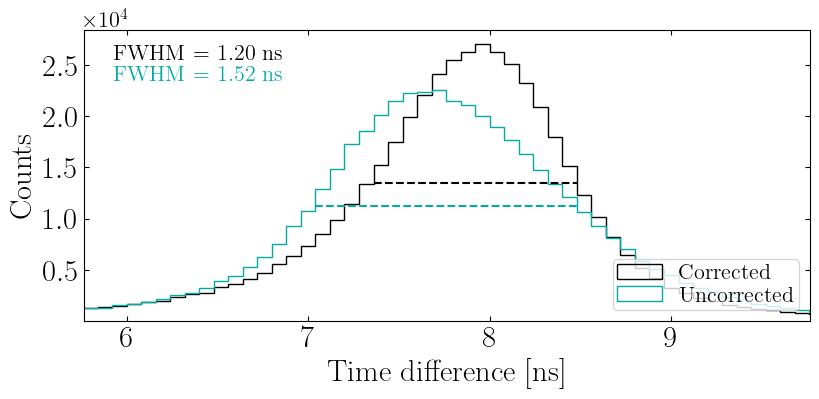

In [204]:
file = uproot.open("output/velocity.root")
correctedTH1 = file["run14/correctedSpectrum 14;1"]
uncorrectedTH1 = file["run14/uncorrectedSpectrum 14;1"]
corrected = correctedTH1.to_numpy()
uncorrected = uncorrectedTH1.to_numpy()

fig, ax = plt.subplots(figsize=(cm2inch(23.8), cm2inch(9.6)))
hist1 = ax.hist(corrected[1][1:]-abs(0.5*(corrected[1][0] - corrected[1][1]))-5.23657, weights=corrected[0]/1e4, bins = np.linspace(min(corrected[1]), max(corrected[1]), len(corrected[1]-1)), 
                histtype=u'step', label="Corrected", color="black")
hist2 = ax.hist(uncorrected[1][1:]-abs(0.5*(uncorrected[1][0] - uncorrected[1][1]))-5.23657, weights=uncorrected[0]/1e4, bins = np.linspace(min(uncorrected[1]), max(uncorrected[1]), len(uncorrected[1]-1)), 
                histtype=u'step', label="Uncorrected", color = "#00ABA4") #-5.23757 is the delay for the bar relative to source at x = 0. 
ax.set_xlim(11-5.23657,15-5.23657)
ax.set_xlabel(r"Time difference [ns]")
ax.set_ylabel(r"Counts")
ax.set_yticks((np.linspace(0.5, 2.5,5)))
ax.legend(loc="lower right", labelspacing=0.1, borderpad = 0.2, fontsize=16)
ax.text(-0.0, 1.07, r"$\times 10^4$", transform=ax.transAxes, fontsize=16, verticalalignment="top")

#find FWHM of the corrected spectrum
maxbin = np.argmax(hist1[0])
halfmax = hist1[0][maxbin]/2
leftbin = maxbin
rightbin = maxbin
while hist1[0][leftbin] > halfmax:
    leftbin -= 1
while hist1[0][rightbin] > halfmax:
    rightbin += 1
FWHM = hist1[1][rightbin] - hist1[1][leftbin]
#plot a line at the FWHM
ax.plot([hist1[1][leftbin+1], hist1[1][rightbin]], [halfmax, halfmax], color="black", linestyle="--")

#print the FWHM on the plot
ax.text(0.04, 0.95, r"FWHM = %.2f ns" % FWHM, transform=ax.transAxes, fontsize=16, verticalalignment="top")

#find FWHM of the uncorrected spectrum
maxbin = np.argmax(hist2[0])
halfmax = hist2[0][maxbin]/2
leftbin = maxbin
rightbin = maxbin
while hist2[0][leftbin] > halfmax:
    leftbin -= 1
while hist2[0][rightbin] > halfmax:
    rightbin += 1
FWHM = hist2[1][rightbin] - hist2[1][leftbin]
#plot a line at the FWHM
ax.plot([hist2[1][leftbin+1], hist2[1][rightbin]], [halfmax, halfmax], color="#00ABA4", linestyle="--")

#print the FWHM on the plot
ax.text(0.04, 0.88, r"FWHM = %.2f ns" % FWHM, transform=ax.transAxes, fontsize=16, verticalalignment="top", color = "#00ABA4")

fig.savefig("../../indiePlakat/walkResolution.svg", bbox_inches="tight", transparent=True)

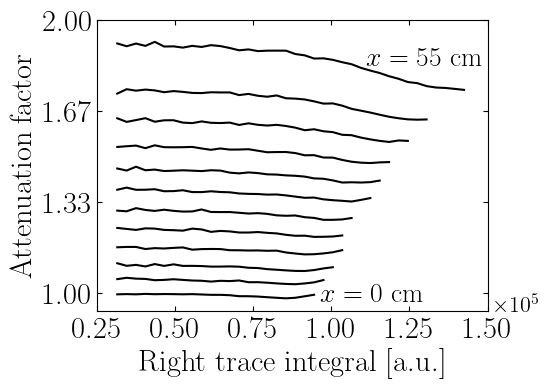

In [256]:
graphs = []
runNos = [2,3,4,5,6,7,8,9,10,11,12,14]
for i in range(len(runNos)): 
    file = uproot.open(f"output/attn_{runNos[i]}.root")
    graph = file["Attenuation Graph"]
    graph = graph.values()
    graphs.append(graph)

toSkip = 10
for i in range(len(graphs)):
    graphs[i] = (graphs[i][0][toSkip:], graphs[i][1][toSkip:])

fig, ax = plt.subplots(figsize=(cm2inch(12.8), cm2inch(9.6)))
for i in range(len(graphs)):
    ax.plot(graphs[i][1]/1e5, graphs[i][1]/graphs[i][0],color="black")
ax.set_xlabel(r"Right trace integral [a.u.]")
ax.set_ylabel(r"Attenuation factor")

ax.text(1.02, 0.06, r"$\times 10^5$", transform=ax.transAxes, fontsize=16, verticalalignment="top")
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.text(0.57, 0.1, r"$x=0$ cm", transform=ax.transAxes, fontsize=20, verticalalignment="top")

ax.text(0.69, 0.91, r"$x=55$ cm", transform=ax.transAxes, fontsize=20, verticalalignment="top")

ax.set_yticks((np.linspace(1, 2,4)))
ax.set_xticks((np.linspace(0.25, 1.5,6)))

fig.savefig("../../indiePlakat/attenuation.svg", bbox_inches="tight", transparent=True)

/tmp/ipykernel_43721/818921461.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x/1e4 for x in ax.get_yticks()])


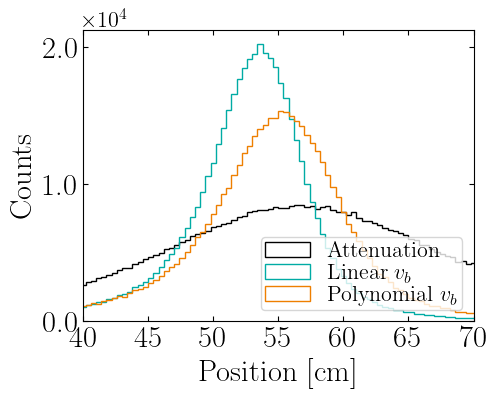

In [283]:
file = uproot.open(f"output/centerPositionTest.root")
attenuationHist = file["Pos spectrum"]
attenuationHist = attenuationHist.to_numpy()
attenuationHist = (attenuationHist[0], attenuationHist[1][1:] - 0.5*(attenuationHist[1][1] - attenuationHist[1][0]) )

file = uproot.open(f"output/velocity.root")
linHist = file["run14/posSpectrumLin 14"]
linHist = linHist.to_numpy()
linHist = (linHist[0], linHist[1][1:] - 0.5*(linHist[1][1] - linHist[1][0]) )

file = uproot.open(f"output/velocity.root")
poly2Hist = file["run14/posSpectrumPoly2 14"]
poly2Hist = poly2Hist.to_numpy()
poly2Hist = (poly2Hist[0], poly2Hist[1][1:] - 0.5*(poly2Hist[1][1] - poly2Hist[1][0]) )

fig, ax = plt.subplots(figsize=(cm2inch(12.8), cm2inch(9.6)))
hist1 = ax.hist(attenuationHist[1], weights=attenuationHist[0], bins = np.linspace(min(attenuationHist[1]), max(attenuationHist[1]), len(attenuationHist[1]-1)), 
                histtype=u'step', color="black", label = "Attenuation")
hist2 = ax.hist(linHist[1], weights=linHist[0], bins = np.linspace(min(linHist[1]), max(linHist[1]), len(linHist[1]-1)),
                histtype=u'step', color = "#00ABA4", label = "Linear $v_b$")
hist3 = ax.hist(poly2Hist[1], weights=poly2Hist[0], bins = np.linspace(min(poly2Hist[1]), max(poly2Hist[1]), len(poly2Hist[1]-1)),
                histtype=u'step', color = "#ee7f00", label = "Polynomial $v_b$")

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))

ax.set_xticks((np.linspace(40, 70,7)))

ax.set_xlabel(r"Position [cm]")
ax.set_ylabel(r"Counts")
ax.set_xlim(40,70)

ax.legend(loc="lower right", labelspacing=0.1, borderpad = 0.2, fontsize=16)

#change yticks to 1e4
ax.text(-0.0, 1.07, r"$\times 10^4$", transform=ax.transAxes, fontsize=16, verticalalignment="top")
ax.set_yticklabels([x/1e4 for x in ax.get_yticks()])

fig.savefig("../../indiePlakat/positioning.svg", bbox_inches="tight", transparent=True)